#### Connect to Polygon.io API

In [98]:
pip install polygon-api-client

Note: you may need to restart the kernel to use updated packages.


#### Import Modules

In [152]:
from polygon import RESTClient
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
from urllib.request import urlopen
import time
import requests

 #### API key from config: https://polygon-api-client.readthedocs.io/en/latest/Getting-Started.html

In [100]:
polygonAPIkey = "api_key_here"
client = RESTClient(polygonAPIkey, verbose = True) #polygonAPIkey is used
client

#### Get the list of exchanges in the USA

Note: I find that the JSON file for ticker details is much more accurate when it comes to active tickers however, max per page is 1000 tickers and it is paginated so unless we have the paid version, I working on a script to obtain multiple json files without triggering the max api call error. 

For now, I used the list_ticker function to create a list of active tickers, but it is not clean. 

In [47]:
exchanges = pd.DataFrame(client.get_exchanges(asset_class='stocks', locale='us'))

In [48]:
exchangeList = list(set(exchanges.mic))

In [49]:
exchangeList.remove(None)

In [50]:
print(exchangeList)

['EDGX', 'XNYS', 'CBSX', 'XCIS', 'XADF', 'LTSE', 'BATY', 'XASE', 'OOTC', 'BATS', 'FINN', 'XNAS', 'IEXG', 'XCHI', 'FINY', 'FINC', 'XPHL', 'EPRL', 'XISE', 'XBOS', 'ARCX', 'MEMX', 'EDGA']


#### Get the list of tickers from all the exchanges in the USA

In [72]:
usTickers = []
api_calls_count = 0  # Initialize the count of API calls made

for x in exchangeList:
    # page through response
    for t in client.list_tickers(market='stocks',
                                 exchange=x,
                                 active=True,
                                 limit=1000):
        # add to list
        usTickers.append(t.ticker)
        api_calls_count += 1  # Increment the count of API calls made
        
        # Check if 1 API calls have been made
        if api_calls_count % 1 == 0:
            print("Delaying for 15 seconds...")
            time.sleep(15)  # Introduce a 15 sec delay after every API call 5 calls / min
        
    # print exchange when finished looping through exchange for active US stock tickers
    print(x)


###NOTE: this code is still including delisted tickers and active tickers that do not have any data

In [2]:
usTickersDF = pd.DataFrame(usTickers) ## this df does NOT include all tickers, max call error was triggered at some point

In [138]:
usTickersDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2981 entries, 0 to 2980
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       2981 non-null   object
dtypes: object(1)
memory usage: 23.4+ KB


In [140]:
usTickersDF.head()

,0
0,A
1,AA
2,AACT
3,AACT.U
4,AACT.WS


#### Get aggregate data for stock ticker 
Plan: use the usTickersList (when completed) in a loop function to scrape polygon.io to add aggregate data to activeUsTickersDB

In [141]:
aggUsTickersDf= usTickersDF
aggUsTickersDf

#need to filter out inactive stock tickers

,0
0,A
1,AA
2,AACT
3,AACT.U
4,AACT.WS
...,...
2976,ZTR
2977,ZTS
2978,ZUO
2979,ZVIA


In [145]:
aggUsTickersDf.iloc[0, 0]

'A'

In [156]:
stockPriceRequest = client.get_aggs(ticker = aggUsTickersDf.iloc[1, 0],
                                   multiplier = 1, 
                                   timespan = 'day',
                                   from_ = "2022-03-22",
                                   to = '2024-03-22')

## Need to iterate through the dataframe of active tickers once full df of active tickers is set up

In [157]:
stockPriceDB = pd.DataFrame(stockPriceRequest)

In [158]:
stockPriceDB #specific ticker ex: "AA"

,open,high,low,close,volume,vwap,timestamp,transactions,otc
0,90.64,92.870,88.1100,92.46,5111285.0,91.5145,1648440000000,55764,None
1,86.50,90.100,84.1295,90.07,7530657.0,88.1407,1648526400000,86795,None
2,92.60,93.990,90.9600,92.19,5513570.0,92.1627,1648612800000,58465,None
3,91.67,92.700,89.8006,90.03,4567221.0,91.1805,1648699200000,52497,None
4,91.69,93.580,87.5350,90.62,5746311.0,90.4137,1648785600000,64440,None
...,...,...,...,...,...,...,...,...,...
495,30.94,31.660,30.7900,31.03,6844237.0,31.2471,1710734400000,51220,None
496,30.30,30.470,28.7200,29.67,9888748.0,29.3871,1710820800000,72847,None
497,29.63,31.880,29.5200,31.35,7446940.0,30.9679,1710907200000,63363,None
498,31.71,32.130,31.0500,31.35,5594696.0,31.5260,1710993600000,46313,None


#### Change Timestamp to datetime

In [159]:
stockPriceDB['Date'] = stockPriceDB['timestamp'].apply(
                            lambda x: pd.to_datetime(x*1000000))

# stockPriceData['Date'] = pd.to_datetime(stockPriceData['timestamp'])

stockPriceDB = stockPriceDB.set_index('Date')

In [160]:
stockPriceDB

,open,high,low,close,volume,vwap,timestamp,transactions,otc
Date,,,,,,,,,
2022-03-28 04:00:00,90.64,92.870,88.1100,92.46,5111285.0,91.5145,1648440000000,55764,None
2022-03-29 04:00:00,86.50,90.100,84.1295,90.07,7530657.0,88.1407,1648526400000,86795,None
2022-03-30 04:00:00,92.60,93.990,90.9600,92.19,5513570.0,92.1627,1648612800000,58465,None
2022-03-31 04:00:00,91.67,92.700,89.8006,90.03,4567221.0,91.1805,1648699200000,52497,None
2022-04-01 04:00:00,91.69,93.580,87.5350,90.62,5746311.0,90.4137,1648785600000,64440,None
...,...,...,...,...,...,...,...,...,...
2024-03-18 04:00:00,30.94,31.660,30.7900,31.03,6844237.0,31.2471,1710734400000,51220,None
2024-03-19 04:00:00,30.30,30.470,28.7200,29.67,9888748.0,29.3871,1710820800000,72847,None
2024-03-20 04:00:00,29.63,31.880,29.5200,31.35,7446940.0,30.9679,1710907200000,63363,None


#### Create simple plot for the historical data (2 years) of a specified ticker

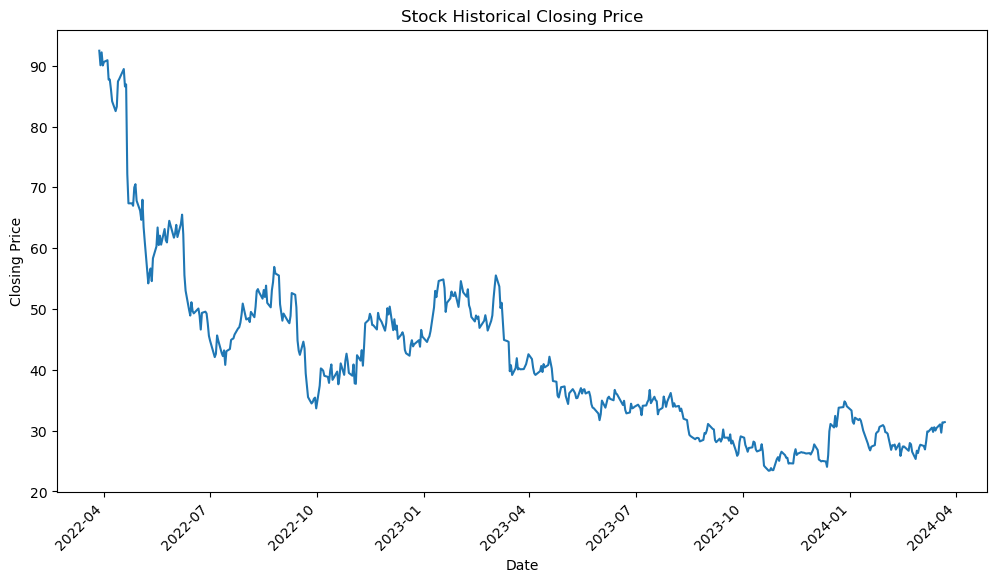

In [161]:
plt.figure(figsize=(12,6))
plt.plot(stockPriceDB["close"])
plt.title("Stock Historical Closing Price")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.show()